# EE5907 Programming Assignment Q3
Lee Jianwei
A0018867

In [1]:
from __future__ import division
import scipy.io
from scipy.stats import norm
import numpy as np
import matplotlib.pyplot as plt

from multiprocessing import Pool
np.set_printoptions(precision=2, suppress=True)

# Load Data

In [2]:
d = scipy.io.loadmat('spamData.mat')
ytest = d['ytest'].flatten()
ytrain = d['ytrain'].flatten()
xtest = d['Xtest']
xtrain = d['Xtrain']

In [3]:
def binarize(array):
    """array: list of emails, each 57 features long"""
    return np.array([x>0 for x in array]).astype('uint8')
xtrainBin = binarize(xtrain)
xtestBin = binarize(xtest)

In [4]:
#z-normalise features
def znorm1D(array1D):
    m = np.mean(array1D)
    s = np.std(array1D)
    return np.array((array1D-m)/s)
def znorm2D(array2D):
    """znorm along columns of 2D array"""
    znormed_columns = np.array([znorm1D(c) for c in array2D.T]) # each column in array2D is a row (called c) in array2D.T
    return znormed_columns.T
xtrainZ = znorm2D(xtrain)
xtestZ = znorm2D(xtest)

In [5]:
#log-transform features
def log2D(array):
    """array: list of emails, each 57 features long"""
    return np.array([np.log(x+0.1) for x in array]).astype('uint8') #x is a 57 element array
xtrainLog = log2D(xtrain)
xtestLog = log2D(xtest)

In [6]:
classMLE = np.average(ytrain)

In [7]:
def sigmoid(x):
    return 1/(1 + np.exp(-x))

In [8]:
def reg_params(x_array2D, y_array1D, w, lamb):
    """returns NLL, g, H"""
    N_features = x_array2D.shape[1] # number of features per mail: default is 57
    x_array2D = np.insert(x_array2D,0,1,axis=1) # modify feature list to include a 1 at the start

    mu = sigmoid(np.dot(x_array2D, w)) # array1D of mus, one for each email
    NLL = -np.sum([y*np.log(m) + (1-y)*np.log(1-m) for y,m in zip (y_array1D, mu)])
    g = np.dot(x_array2D.T,(mu-y_array1D))
    S = np.diag(mu*(1-mu))
    H = np.dot(x_array2D.T, np.dot(S, x_array2D))
    
    NLL_reg = NLL + 0.5*lamb*np.inner(w[1:],w[1:])
    g_reg = g + np.insert(lamb*w[1:],0,0) # first element of g is unregularised
    H_reg = H + np.diag(np.insert(lamb*np.ones(N_features),0,0)) # first diagonal element is unregularised
    
#     print x_array2D
#     print mu
    
    return NLL_reg, g_reg, H_reg


In [9]:
NLL_reg, g_reg, H_reg = reg_params(xtrainZ,ytrain,np.ones(58),1)

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:7: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:7: RuntimeWarning: invalid value encountered in multiply


In [27]:
def omega(x_array2D, y_array1D, lamb):
    """
    this function implements Newton's method for logistic regression to find w which describes the dataset x_array2D, yarray1D
    """
    """initialisation"""
    N_features = x_array2D.shape[1]
    wInit = np.zeros(N_features+1)
    w = wInit
    converge = False 
    counter = 0
    try:
        while converge==False:
            _, g, H = reg_params(x_array2D, y_array1D, w, lamb)
            counter += 1
            w_new = w - np.dot(np.linalg.inv(np.dot(H.T,H)),np.dot(H.T,g)) # numerically more stable than inv(H).g
    #         w_new = w - np.dot(np.linalg.inv(H),g)
            error = np.inner(w_new-w,w_new-w)/np.inner(w,w)
            if  error < 0.001:
                """arbitrary error threshold set to 0.1%"""
                converge = True
            else:
                w = w_new
        return w_new
    except:
        print ('lambda = {}\n iteration = {}\n w_new-w = {:.5f}%\n, g = {}\n H = {}\n'.format(lamb, counter, error*100, g, H))

In [28]:
def LogReg_ErrorRate(x_array2D, y_array1D, x_training_array2D, y_training_array1D, lamb):
    """
    uses omega to classify an array of emails x_array2D
    compares results with y_array1D to check for error rate
    """
    w = omega(x_training_array2D,y_training_array1D,lamb)
    category = sigmoid(w[0]+np.dot(x_array2D, w[1:]))>0.5
    category_error = np.logical_xor(category,y_array1D)
    error_rate =  np.sum(category_error)/len(y_array1D)
    return error_rate

In [29]:
lambdas = np.insert(np.arange(15,105,5),0,np.arange(1,11,1))
print lambdas

[  1   2   3   4   5   6   7   8   9  10  15  20  25  30  35  40  45  50
  55  60  65  70  75  80  85  90  95 100]


# Binarised Data

In [27]:
TrainingBin_ErrorRates = map(lambda lamb: LogReg_ErrorRate(xtrainBin,ytrain,xtrainBin,ytrain,lamb), lambdas)

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:17: RuntimeWarning: divide by zero encountered in double_scalars


In [34]:
np.savetxt('LogisticRegression_TrainingBinErrorRates',zip(lambdas,TrainingBin_ErrorRates),header='lambdas\tTrainingBin_ErrorRate')

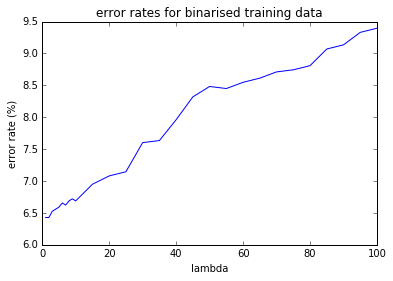

In [35]:
plt.figure()
plt.title('error rates for binarised training data')
plt.plot(lambdas, np.array(Training_ErrorRates)*100)
plt.xlabel('lambda')
plt.ylabel('error rate (%)')
plt.show()

In [38]:
# Error rates for training data for lambda = 1,10,100
map(lambda lamb: LogReg_ErrorRate(xtrainBin,ytrain,xtrainBin,ytrain,lamb), [1,10,100])

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:17: RuntimeWarning: divide by zero encountered in double_scalars


[0.064274061990212072, 0.066884176182707991, 0.093964110929853184]

In [38]:
TestingBin_ErrorRates = map(lambda lamb: LogReg_ErrorRate(xtestBin,ytest,xtrainBin,ytrain,lamb), lambdas)

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:17: RuntimeWarning: divide by zero encountered in double_scalars


In [39]:
np.savetxt('LogisticRegression_TestingBinErrorRates',zip(lambdas,TestingBin_ErrorRates),header='lambdas\tTestingBin_ErrorRate')

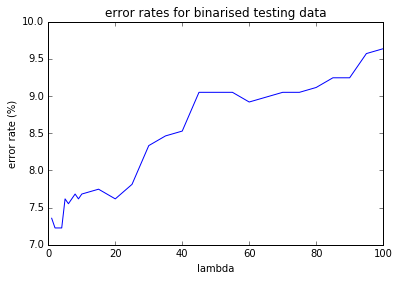

In [42]:
plt.figure()
plt.title('error rates for binarised testing data')
plt.plot(lambdas, np.array(TestingBin_ErrorRates)*100)
plt.xlabel('lambda')
plt.ylabel('error rate (%)')
plt.show()

In [39]:
# Error rates for testing data for lambda = 1,10,100
map(lambda lamb: LogReg_ErrorRate(xtestBin,ytest,xtrainBin,ytrain,lamb), [1,10,100])

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:17: RuntimeWarning: divide by zero encountered in double_scalars


[0.073567708333333329, 0.076822916666666671, 0.096354166666666671]

# Z-normed Data

In [46]:
TrainingZ_ErrorRates = map(lambda lamb: LogReg_ErrorRate(xtrainZ,ytrain,xtrainZ,ytrain,lamb), lambdas)

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:17: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:7: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:7: RuntimeWarning: invalid value encountered in multiply


In [47]:
np.savetxt('LogisticRegression_TrainingZErrorRates',zip(lambdas,TrainingZ_ErrorRates),header='lambdas\tTrainingZ_ErrorRate')

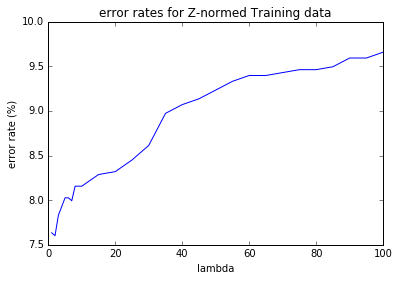

In [48]:
plt.figure()
plt.title('error rates for Z-normed Training data')
plt.plot(lambdas, np.array(TrainingZ_ErrorRates)*100)
plt.xlabel('lambda')
plt.ylabel('error rate (%)')
plt.show()

In [40]:
# Error rates for training data for lambda = 1,10,100
map(lambda lamb: LogReg_ErrorRate(xtrainZ,ytrain,xtrainZ,ytrain,lamb), [1,10,100])

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:17: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:7: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:7: RuntimeWarning: invalid value encountered in multiply


[0.076345840130505715, 0.081566068515497553, 0.096574225122349103]

In [43]:
TestingZ_ErrorRates = map(lambda lamb: LogReg_ErrorRate(xtestZ,ytest,xtrainZ,ytrain,lamb), lambdas)

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:17: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:7: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:7: RuntimeWarning: invalid value encountered in multiply


In [44]:
np.savetxt('LogisticRegression_TestingZErrorRates',zip(lambdas,TestingZ_ErrorRates),header='lambdas\tTestingZ_ErrorRate')

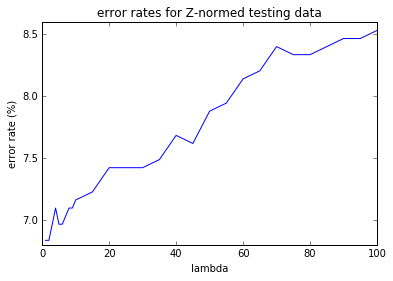

In [49]:
plt.figure()
plt.title('error rates for Z-normed testing data')
plt.plot(lambdas, np.array(TestingZ_ErrorRates)*100)
plt.xlabel('lambda')
plt.ylabel('error rate (%)')
plt.show()

In [41]:
# Error rates for testing data for lambda = 1,10,100
map(lambda lamb: LogReg_ErrorRate(xtestZ,ytest,xtrainZ,ytrain,lamb), [1,10,100])

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:17: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:7: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:7: RuntimeWarning: invalid value encountered in multiply


[0.068359375, 0.071614583333333329, 0.085286458333333329]

# Log Data

In [30]:
# TrainingLog_ErrorRates = map(lambda lamb: LogReg_ErrorRate(xtrainLog,ytrain,xtrainLog,ytrain,lamb), lambdas)
TrainingLog_ErrorRates = []
valid_lambdas = []
invalid_lambdas = []
for lamb in lambdas:
    try:
        TrainingLog_ErrorRates.append(LogReg_ErrorRate(xtrainLog,ytrain,xtrainLog,ytrain,lamb))
        valid_lambdas.append(lamb)
    except:
        invalid_lambdas.append(lamb)
        pass

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:17: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:7: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:2: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:7: RuntimeWarning: invalid value encountered in multiply


lambda = 5
 iteration = 15
 w_new-w = 1579.31781%
, g = [    44.   -24727.97 -12075.81  -7324.19   7382.99  -2136.47  19279.71
   1570.51  -6010.68 -35303.36 -29220.89   -965.89 -70641.78   6448.01
  11441.15  13251.03  33201.57 -10262.88  21185.04 -22560.66   3597.36
 -23397.61   4860.06  -2222.18  -5716.21  -1821.91  18050.23   4838.57
  16019.56   6879.33   8397.39   7118.01   9405.36 -34544.07   9150.1
  14744.49  11936.4   47943.24   7381.3  -32489.54   3574.36  29705.94
   6029.38  14997.54  -8816.78  80102.7   45293.23  12965.27  21067.95
  10484.8   27260.78  15753.87 -81277.2   -7100.01    281.61    478.84
    563.92    588.54]
 H = [[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  5.  0. ...,  0.  0.  0.]
 [ 0.  0.  5. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  5.  0.  0.]
 [ 0.  0.  0. ...,  0.  5.  0.]
 [ 0.  0.  0. ...,  0.  0.  5.]]

lambda = 50
 iteration = 15
 w_new-w = 291903186758369029059961826031931702944496117884081303758395004391855436981980551522072463237185536.00000%
, g

In [33]:
np.savetxt('LogisticRegression_TrainingLogErrorRates',zip(valid_lambdas,TrainingLog_ErrorRates),header='lambdas\tTrainingLog_ErrorRate')

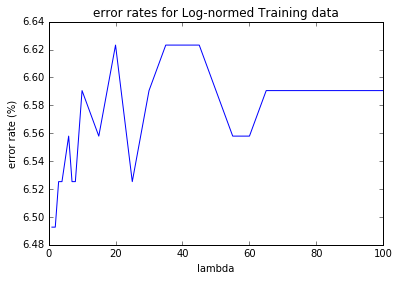

In [34]:
plt.figure()
plt.title('error rates for Log-normed Training data')
plt.plot(valid_lambdas, np.array(TrainingLog_ErrorRates)*100)
plt.xlabel('lambda')
plt.ylabel('error rate (%)')
plt.show()

In [42]:
# Error rates for training data for lambda = 1,10,100
map(lambda lamb: LogReg_ErrorRate(xtrainLog,ytrain,xtrainLog,ytrain,lamb), [1,10,100])

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:17: RuntimeWarning: divide by zero encountered in double_scalars


[0.064926590538336049, 0.065905383360522027, 0.065905383360522027]

In [35]:
# TestingLog_ErrorRates = map(lambda lamb: LogReg_ErrorRate(xtrainLog,ytrain,xtrainLog,ytrain,lamb), lambdas)
TestingLog_ErrorRates = []
valid_lambdas = []
invalid_lambdas = []
for lamb in lambdas:
    try:
        TestingLog_ErrorRates.append(LogReg_ErrorRate(xtestLog,ytest,xtrainLog,ytrain,lamb))
        valid_lambdas.append(lamb)
    except:
        invalid_lambdas.append(lamb)
        pass

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:17: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:7: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:2: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:7: RuntimeWarning: invalid value encountered in multiply


lambda = 5
 iteration = 15
 w_new-w = 1579.31781%
, g = [    44.   -24727.97 -12075.81  -7324.19   7382.99  -2136.47  19279.71
   1570.51  -6010.68 -35303.36 -29220.89   -965.89 -70641.78   6448.01
  11441.15  13251.03  33201.57 -10262.88  21185.04 -22560.66   3597.36
 -23397.61   4860.06  -2222.18  -5716.21  -1821.91  18050.23   4838.57
  16019.56   6879.33   8397.39   7118.01   9405.36 -34544.07   9150.1
  14744.49  11936.4   47943.24   7381.3  -32489.54   3574.36  29705.94
   6029.38  14997.54  -8816.78  80102.7   45293.23  12965.27  21067.95
  10484.8   27260.78  15753.87 -81277.2   -7100.01    281.61    478.84
    563.92    588.54]
 H = [[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  5.  0. ...,  0.  0.  0.]
 [ 0.  0.  5. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  5.  0.  0.]
 [ 0.  0.  0. ...,  0.  5.  0.]
 [ 0.  0.  0. ...,  0.  0.  5.]]

lambda = 50
 iteration = 15
 w_new-w = 291903186758369029059961826031931702944496117884081303758395004391855436981980551522072463237185536.00000%
, g

In [36]:
np.savetxt('LogisticRegression_TestingLogErrorRates',zip(valid_lambdas,TestingLog_ErrorRates),header='lambdas\tTestingLog_ErrorRate')

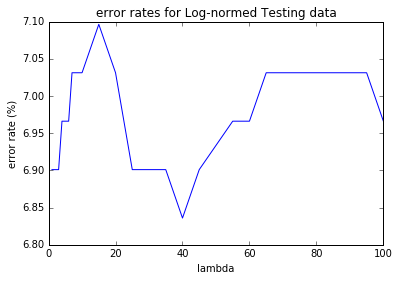

In [37]:
plt.figure()
plt.title('error rates for Log-normed Testing data')
plt.plot(valid_lambdas, np.array(TestingLog_ErrorRates)*100)
plt.xlabel('lambda')
plt.ylabel('error rate (%)')
plt.show()

In [43]:
# Error rates for testing data for lambda = 1,10,100
map(lambda lamb: LogReg_ErrorRate(xtestLog,ytest,xtrainLog,ytrain,lamb), [1,10,100])

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:17: RuntimeWarning: divide by zero encountered in double_scalars


[0.069010416666666671, 0.0703125, 0.069661458333333329]

# Comments
1. The error rates tend to increase with lambda for both binarised and z-normed data, as to be expected as 
2. The error rates for the Log-normed data tend to span smaller values for Log-normed data, moderate values for z-normed data and has the highest values for binarised data.